## [Analysis] - Holiday Analysis, how accurate for each holiday? Is gating correct?

The Task in this story is to determine whether there is a correlation between spikes in the actuals data(shifted N periods of weeks) for different product hierarchies(product category level, ppg level and basecode level) vs different holidays(All or some). The correlation we will use in this story is the point-biserial correlation coefficient. The point biserial correlation coeficient is a correlation coefficient used when one variable is dichotomous: Y can either be "naturally" dichotomous, like whether a coin lands heads or tails, or an artificially dichotomized variable (from wikipedia.com).We first deasonalized and detrended the time series after which we normalized the shipment data by calculating the z score for each data point using the median and standard deviation of the time series of interest and then we encoded the holidays that we would like to use in calculating the correlation. The encoded holidays will serve as the dichotomized variable and the normalized shipment data shifted different N number of weeks serves as the continuous data. The shifted week with highest coefficient determines the best("correct") gating.  

Import relevant packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import os
os.getcwd()
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

Import holidays dataframe

In [2]:
holidaysdf = pd.read_csv("holidaysdf.csv")

Find unique holidays

In [3]:
holidaysdf['Holiday Type 0 Week Offset'].unique()

array(["New Year's Day", nan, 'Martin Luther King, Jr. Day',
       'Super Bowl Sunday', "George Washington's Birthday",
       'Easter,Easter Monday', 'Memorial Day', 'Independence Day',
       'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day'], dtype=object)

Since we have 12 unique holidays we would want to try the point-bisserial correlation against holiday and lags of holidays with each unique combinattion representing a unique scenario. This is the purpose of the function below.

In [25]:
def gating_function(csv,weeks):
    #suppress warnings 
    warnings.filterwarnings("ignore")
    from statsmodels.tsa.seasonal import seasonal_decompose
    #create a list of Holidays 
    holidays_list = ["New Year's Day","MLK Day",
       'Super Bowl Sunday', "George Washington's Birthday",
       'Easter', 'Memorial Day', 'Independence Day',
       'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day']
    #create empty dataframe where all scenarios will eventually get appended to
    empdf = pd.DataFrame(columns=["correlation","pvalue","holiday","week"])
    #upload time series of interest
    timeseries = pd.read_csv(csv)
    #deseasonalize and detrend data
    result=seasonal_decompose(timeseries['Time Series'].dropna(), period=52)
    timeseries['Time Series'] = result.resid
    #calcuate time series mean
    timeseriesmean = timeseries['Time Series'].mean()
    #calculate time series standard deviation
    timeseriesstd = timeseries['Time Series'].std()
    #create time series z score column
    timeseries['timeserieszscores'] = (timeseries['Time Series'] - timeseriesmean)/timeseriesstd
    #Since there are a total of 12 unique combinations of holidays and n different weeks of gating we would have to calculate
    #the point biserialr correlation 12*n times we will then dump the result for each scenario to the empdf data frame
    for holiday in holidays_list:               
        #read holidays csv where are interested in the column with 0 offset
        holidaysdf = pd.read_csv("holidaysdf.csv")
        #copy time series z score column to holidays dataframe
        holidaysdf['timeserieszscores'] = timeseries['timeserieszscores']
        #since we split the strings of holidays using a comma we would to rename certain holidays with comma 
        key = {'Martin Luther King, Jr. Day':'MLK Day','Easter,Easter Monday':'Easter'}
        #rename holidays using key dictionary
        holidaysdf.replace({"Holiday Type 0 Week Offset": key},inplace=True)
        #create holiday encoding column
        holidaysdf['Holiday Type 0 Week Offset Encoding'] = 0
        #fill na's in the Holiday Type 0 Week Offset' column with 0
        holidaysdf['Holiday Type 0 Week Offset']=holidaysdf['Holiday Type 0 Week Offset'].fillna(0)
        holidaysdf.loc[holidaysdf['Holiday Type 0 Week Offset'] == holiday  ,'Holiday Type 0 Week Offset Encoding'] = 1
        #create list of gating weeks we are interested in
        shifts = weeks
        #calculate correlation against each unique combination of holidays and gating/shift
        for shift in shifts:
            #create a new column for each gating week in the holidaysdf dataframe by shifting time series z score column
            holidaysdf['timeserieszscoresshiftedNperiods']=holidaysdf['timeserieszscores'].shift(periods=shift)
            #shifting will result in na values thus we would have to drop those rows
            holidaysdf.dropna(inplace=True)
            #calculate the correlation and save in score variable
            score = stats.pointbiserialr(holidaysdf['Holiday Type 0 Week Offset Encoding'],holidaysdf['timeserieszscoresshiftedNperiods'])           
            #create a dictionary new_row containing correlation, pvalue, holidays, and week
            new_row = {"correlation":score[0],"pvalue":score[1],"holiday":holiday,"week":shift}
            #append new row to empdf
            empdf = empdf.append(new_row,ignore_index=True)
    #Only keep rows with p-values that are statisticall significant
    df1 = empdf[empdf['pvalue'] < 0.05].copy()
    #Only keep scenarios with positive correlation
    df2 = df1[df1['correlation'] > 0].copy()
    #save final csv
    df2.to_csv(csv[:-4]+'results'+'.csv')
    #return csv
    return pd.read_csv(csv[:-4]+'results'+'.csv')
    

    

To test if our gating function is working as expected, we test our function against stuffing which we now has a spike in demand during Thanksgiving.

   Unnamed: 0  correlation    pvalue           holiday  week
0          41     0.234661  0.011228  Thanksgiving Day     3
1          47     0.209253  0.030532     Christmas Day     5


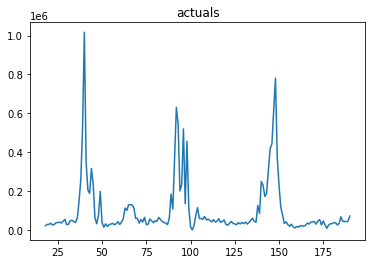

In [44]:
stuffing_csv = pd.read_csv('timeseriesstuffing.csv')
stuffing = gating_function('timeseriesstuffing.csv',[2,3,4,5])
stuffing_csv['Time Series'].plot(title = 'actuals')
print(stuffing)

According to our gating function the correct gating for Thanksgiving is 3 weeks and the Correct gating for Christmas is 5 weeks. Now since Christmas and Thanksgiving are only 4 weeks apart therefore the significant correlation for Christmas at 5 weeks must be thrown away since essentially the spike before Thanksgiving is what the gating function is reading as correlation at 5 weeks of gating.

Next we examine shipments on a product level we first examine product category 16 which is Bacon and Breakfast Sausage.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


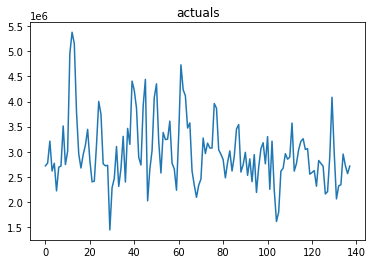

In [43]:
BaconandBreakfastSausage_csv = pd.read_csv('timeseries16.csv')
BaconandBreakfastSausage = gating_function('timeseries16.csv',[2,3,4,5])
BaconandBreakfastSausage_csv['Time Series'].plot(title = 'actuals')
print(BaconandBreakfastSausage)

For this particular ppg there are no weeks that are no gating weeks that are correlated to any of the holidays. Next we examine the forecast for this ppg to see if the results are consistent.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


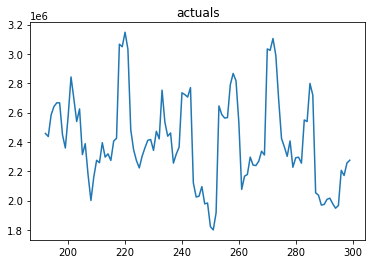

In [42]:
BaconandBreakfastSausageforecast_csv = pd.read_csv('timeseries16forecast.csv')
BaconandBreakfastSausageforecast = gating_function('timeseries16forecast.csv',[2,3,4,5])
BaconandBreakfastSausageforecast_csv['Time Series'].plot(title = 'actuals')
print(BaconandBreakfastSausageforecast)

The results are consistent there are also no statistically significant correlations for weeks 2,3,4 and 5 of gating.

Next we examine product category 38 which is Hotdogs. 

   Unnamed: 0  correlation    pvalue    holiday  week
0          31     0.269335  0.022147  Labor Day     5


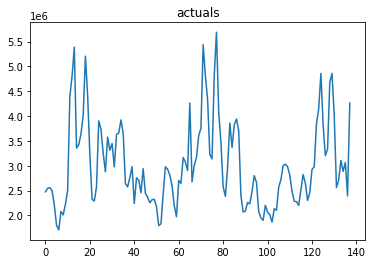

In [40]:
Hotdogs_csv = pd.read_csv('timeseries38.csv')
Hotdogs = gating_function('timeseries38.csv',[2,3,4,5])
Hotdogs_csv['Time Series'].plot(title = 'actuals')
print(Hotdogs)

According to our gating function there is a spike in shipment 5 weeks before labor day which makes sense intuitively because there is a significant uptick in demand for hotdogs during labor day.

Next we examine the marshmallows product category

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


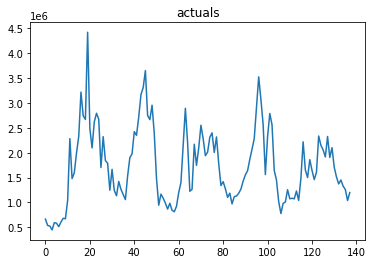

In [41]:
Marshmallows_csv = pd.read_csv('timeseries294.csv')
Marshmallows = gating_function('timeseries294.csv',[2,3,4,5])
Marshmallows_csv['Time Series'].plot(title = 'actuals')
print(Marshmallows)

Next we examine the forecast of the Marshmallows product category to examine the consistency of results of the gating function.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


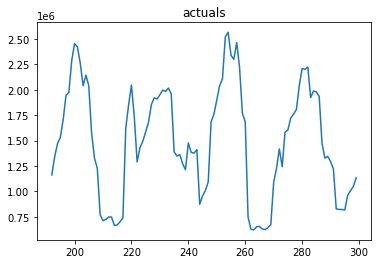

In [45]:
Marshmallowsforecast_csv = pd.read_csv('timeseries294forecast.csv')
Marshmallowsforecast = gating_function('timeseries294forecast.csv',[2,3,4,5])
Marshmallowsforecast_csv['Time Series'].plot(title = 'actuals')
print(Marshmallowsforecast)

Our results are consistent there are no statistically significant correlations for any weeks of gating even for the forecasted values.

Next we examine the ketchup product category.

   Unnamed: 0  correlation    pvalue       holiday  week
0          21     0.249523  0.003643  Memorial Day     3


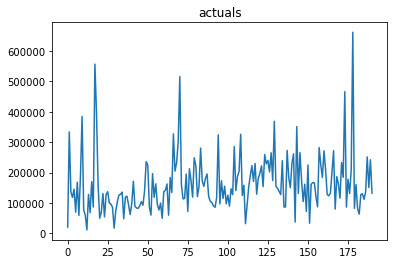

In [58]:
Ketchup_csv = pd.read_csv('timeseries233.csv')
Ketchup = gating_function('timeseries233.csv',[2,3,4,5])
Ketchup_csv['Time Series'].plot(title = 'actuals')
print(Ketchup)

It makes sense that there is a spike in ketchup demand prior to memorial day since it is during memorial day and labor day when the demand for hotdogs spike as well. Although in our previous analysis we only saw a statistically correlated spike before labor day.


Next we examine the forecast for the hotdog category.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


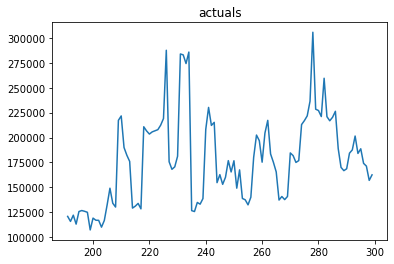

In [60]:
Ketchupforecast_csv = pd.read_csv('timeseries233forecast.csv')
Ketchupforecast = gating_function('timeseries233forecast.csv',[2,3,4,5])
Ketchupforecast_csv['Time Series'].plot(title = 'actuals')
print(Ketchupforecast)

Unlike the actuals data the forecasted value and the best fit model did not capture a week with a a holiday with a correlated spike.

Next we will examine a scenario wherein we imputed the actuals value for a case where there is a period of time when there is a service issue and check if that captures any holiday with a correlation. In this particular case we are examining a base code.

In [95]:
timeseriesbeforeimputation = pd.read_csv('timeseries273_000000210000674700.csv')
timeseriesafterimputation = pd.read_csv ('timeseries273_000000210000674700imputed.csv')

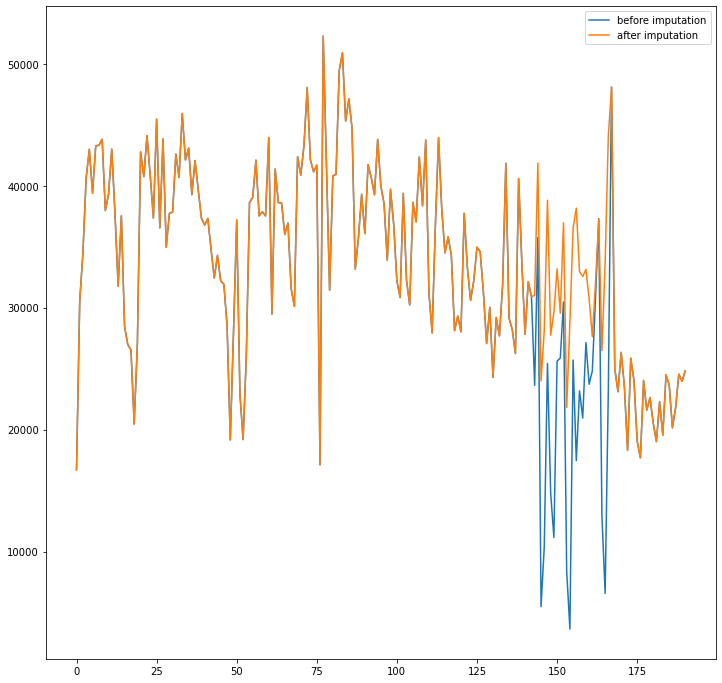

In [96]:
plt.figure(figsize=(12, 12))
plt.plot(timeseriesbeforeimputation['Time Series'] , label = "before imputation")
plt.plot(timeseriesafterimputation['Time Series'] , label = "after imputation",)
plt.legend()
plt.show()

We imputed the values between week 40 - 2021 and week 11 - 2022 using the actual orders for the shipments.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


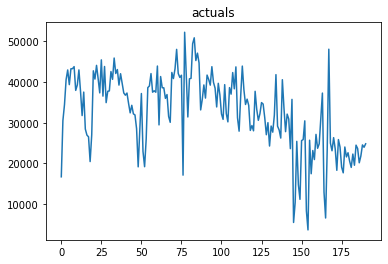

In [101]:
timeseriesbeforeimputation_csv = pd.read_csv('timeseries273_000000210000674700.csv')
timeseriesbeforeimputation = gating_function('timeseries273_000000210000674700.csv',[2,3,4,5])
timeseriesbeforeimputation_csv['Time Series'].plot(title = 'actuals')
print(timeseriesbeforeimputation)

No correlated weeks for any of the holidays were found prior to imputation.

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


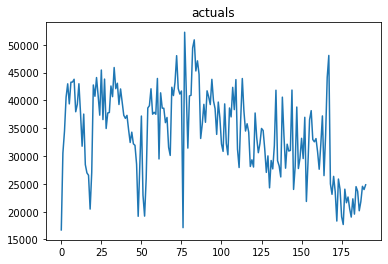

In [103]:
timeseriesafterimputation_csv = pd.read_csv('timeseries273_000000210000674700imputed.csv')
timeseriesaftereimputation = gating_function('timeseries273_000000210000674700imputed.csv',[2,3,4,5])
timeseriesafterimputation_csv['Time Series'].plot(title = 'actuals')
print(timeseriesaftereimputation)

Likewise no correlated weeks were found even after imputation.

Next we examine the forecast for the same basecode

Empty DataFrame
Columns: [Unnamed: 0, correlation, pvalue, holiday, week]
Index: []


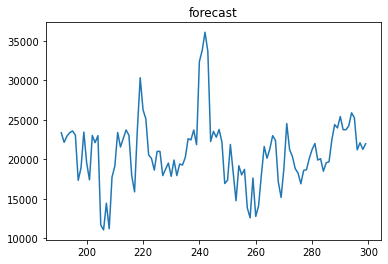

In [108]:
timeseriesafterforecast_csv = pd.read_csv('timeseries273_000000210000674700forecast.csv')
timeseriesafterforecast = gating_function('timeseries273_000000210000674700forecast.csv',[2,3,4,5])
timeseriesafterforecast_csv['Time Series'].plot(title = 'forecast')
print(timeseriesafterforecast)

Just like the previous two cases where we examined the correlated weeks and holidays before and after correlation we did not see any correlated weeks and holidays for the forecast which makes the model consistent.

## Summary

 To answer the main question of the story and that is if we are gating our products correctly the answer is it depends. As can be seen from our analysis there are certain product categories/baecodes that are gated correctly at 2 weeks but there are also those based on our analysis that should be gated at 3 weeks or at 5 weeks and there are even product categories/basecodes that do not show any correct gating at all like the case for Marshmallows. In other words there is really no "general rule" when it comes to gating. A 3 week gating might work on one particular product category, ppg, and basecode but it might not work on another one based on this analysis and that this gating varies by hierarchy level. We also saw that even after imputation (replacing the shipment period's actual values with CFR issues with the corresponding orders) that it does not necessarily result in a holiday that is correlated to a shipment spike prior to a holiday. Also we saw that the ML models forecast do not necessarily capture gating as well. The question then arises. Which products does show gating? The answer is products that show a clear seasonal demand. If the product's shipment time series is all over the place like the case for basecode 000000210000674700 then the point-biserial correlation will not see any correlated holiday at all. Finally what this analysis shows is that the only way really to check the correct gating(or if there is any gating at all) for a basecode/ppg/product category is by running a similar analysis individually.  
    